In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
sc = SparkContext('local')
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 16:31:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
schema = StructType([
    StructField("change", StringType(), True),
    StructField("date", StringType(), True),
    StructField("fuelType", StringType(), True),
    StructField("percentChange", StringType(), True),
    StructField("x", StringType(), True),
    StructField("y", StringType(), True)
    # Add more fields as required
])

fuel_map = {"gasoline": "Xăng", "natural-gas": "Khí tự nhiên", "crude-oil": "Dầu thô", "brent-crude-oil": "Dầu hỏa", "heating-oil": "Dầu nóng"}

df = spark.read.csv("hdfs://localhost:9000/*.csv", header=True, schema=schema)

In [3]:
print('Tổng số bản ghi %d' %df.count())

Tổng số bản ghi 28407


In [4]:
countGasoline = df.where(col('fuelType') == 'gasoline').count()
countCrudeOil = df.where(col('fuelType') == 'crude-oil').count()
countNaturalGas = df.where(col('fuelType') == 'natural-gas').count()
countBrent = df.where(col('fuelType') == 'brent-crude-oil').count()
countHeatingOil = df.where(col('fuelType') == 'heating-oil').count()

print('Tổng số bản ghi từng loại:')
print('Xăng: %d' %countGasoline)
print('Dầu thô: %d' %countCrudeOil)
print('Khí tự nhiên: %d' %countNaturalGas)
print('Dầu hỏa: %d' %countBrent)
print('Dầu nóng: %d' %countHeatingOil)

Tổng số bản ghi từng loại:
Xăng: 4398
Dầu thô: 6001
Khí tự nhiên: 5984
Dầu hỏa: 6148
Dầu nóng: 5876


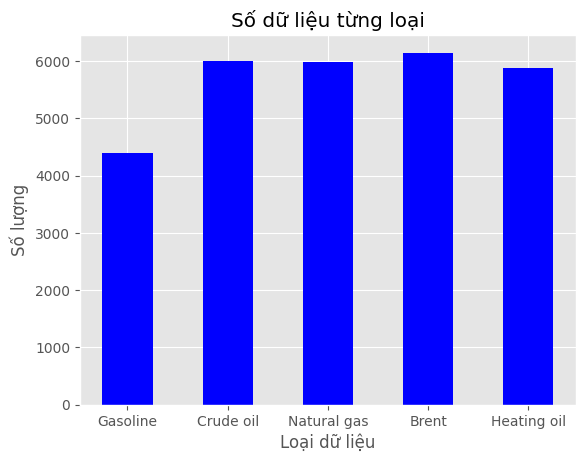

In [5]:
col = ['Gasoline', 'Crude oil', 'Natural gas', 'Brent', 'Heating oil']
countGases = np.array([countGasoline, countCrudeOil, countNaturalGas, countBrent, countHeatingOil])
plt.bar(col, countGases, color='blue', width=0.5, alpha=1)
plt.title('Số dữ liệu từng loại')
plt.xlabel('Loại dữ liệu')
plt.ylabel('Số lượng')
plt.show()

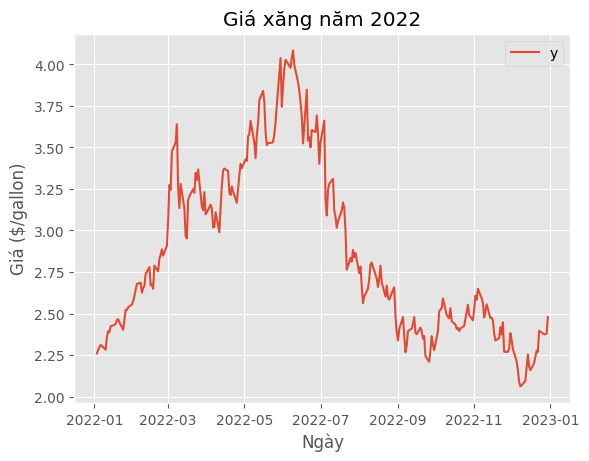

In [6]:
from pyspark.sql.functions import col

dfGasoline = df.where(col('fuelType') == 'gasoline').select('date', 'y')
dfGasoline = dfGasoline.withColumn('y', dfGasoline['y'].cast('float'))
dfGasoline = dfGasoline.withColumn('date', dfGasoline['date'].cast('date'))
dfGasoline = dfGasoline.orderBy('date')\
  .where(col('date') <= '2022-12-31')\
  .where(col('date') >= '2022-01-01')
dfGasoline = dfGasoline.toPandas()
dfGasoline = dfGasoline.set_index('date')
dfGasoline.plot()
plt.title('Giá xăng năm 2022')
plt.xlabel('Ngày')
plt.ylabel('Giá ($/gallon)')
plt.show()

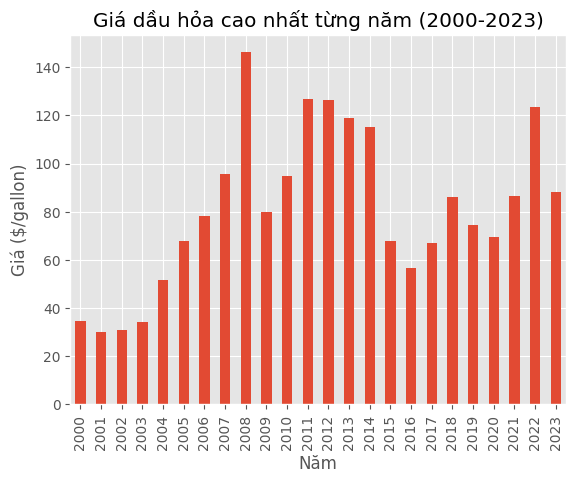

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
dfGasoline = df.where(col('fuelType') == 'brent-crude-oil')
pdf = dfGasoline.toPandas()
# Extract year from "date" field and store it in a new column "year"
pdf['year'] = pd.to_datetime(pdf['date']).dt.year
pdf['y'] = pd.to_numeric(pdf['y'])

# Group the data by year and find the maximum price for each year
grouped_pdf = pdf.groupby(['year'])['y'].max()

# Plot the bar chart
grouped_pdf.plot(kind='bar')

# Set the title and labels
plt.title('Giá dầu hỏa cao nhất từng năm (2000-2023)')
plt.xlabel('Năm')
plt.ylabel('Giá ($/gallon)')

# Show the plot
plt.show()

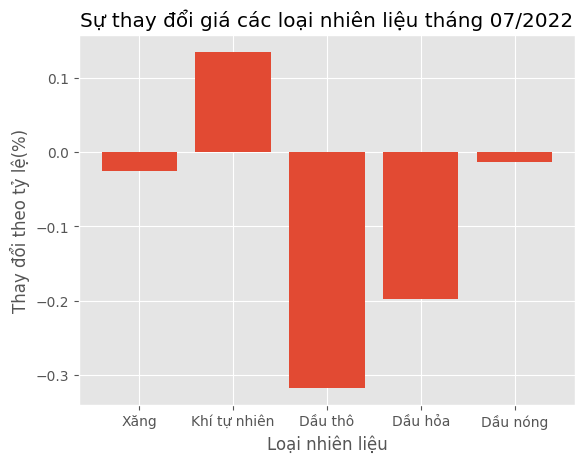

In [8]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# Filter the data for February 2022
df_feb = df.filter((df["date"] >= "2022-07-01") & (df["date"] <= "2022-07-31"))

# Group the data by fuel type and calculate average change for each fuel
fuel_avg = df_feb.groupBy("fuelType").agg(avg("change").alias("avg_change"))

# Create a bar chart to compare average change of each fuel
fuel_types = ["gasoline", "natural-gas", "crude-oil", "brent-crude-oil", "heating-oil"]
fuel_change = [fuel_avg.filter(fuel_avg["fuelType"] == fuel).first()["avg_change"] for fuel in fuel_types]

fig, ax = plt.subplots()
fuel_types_vn = [fuel_map[ft] for ft in fuel_types]
ax.bar(fuel_types_vn, fuel_change)
ax.set_xlabel("Loại nhiên liệu")
ax.set_ylabel("Thay đổi theo tỷ lệ(%)")
ax.set_title("Sự thay đổi giá các loại nhiên liệu tháng 07/2022")

plt.show()
